In [3]:
import pandas as pd
import numpy as np
from time import time
import datetime

# 设定最大显示行数、列数为200
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

from jqdata import *
from jqfactor import *
from jqlib.technical_analysis import *
from scipy import stats
import statsmodels.api as sm
from statsmodels import regression
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams["font.family"] = "SimHei"
mpl.rcParams["axes.unicode_minus"] = False
plt.style.use('ggplot')

# 1.数据获取

## 1.1参数设置


In [11]:
# 样本区间
START_DATE = '2017-01-01'
END_DATE = '2022-01-01'

# 指数成份股 ,比较基准 , 这里用ZZ500
INDEX = '399905.XSHE'
# 排名前0.3为1,后0.3为0
percent_select = [0.3, 0.3]  

### 1.1.1财务数据q

In [12]:
q = query(valuation.code, 
      valuation.market_cap,#市值
      valuation.circulating_market_cap,
      valuation.pe_ratio, #市盈率（TTM）
      valuation.pb_ratio, #市净率（TTM）
      valuation.pcf_ratio, #CFP
      valuation.ps_ratio, #PS
      balance.total_assets,
      balance.total_liability,
      balance.fixed_assets,  
      balance.total_non_current_liability,
      income.operating_profit,
      income.total_profit, #OPTP
      indicator.net_profit_to_total_revenue, #净利润/营业总收入
      indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
      indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
      indicator.roe,
      indicator.roa,
      indicator.gross_profit_margin #销售毛利率GPM
    )

### 1.1.2 聚宽因子列表

In [13]:
# get_factor_values()中的参数factors
jqfactor_list = ['current_ratio',
                  'net_profit_to_total_operate_revenue_ttm',
                  'gross_income_ratio',
                  'roe_ttm',
                  'roa_ttm',
                  'total_asset_turnover_rate',
                  'net_operating_cash_flow_coverage',
                  'net_operate_cash_flow_ttm',
                  'net_profit_ttm',
                  'cash_to_current_liability',
                  'operating_revenue_growth_rate',
                  'non_recurring_gain_loss',
                  'operating_revenue_ttm',
                  'net_profit_growth_rate',
                  'AR',
                  'ARBR',
                  'ATR14',
                  'VOL5',
                  'VOL60',
                  'Skewness20',
                  'Skewness60']

## 1.2获取交易日历(月频)

In [14]:
def get_trade_days_monthly(start,end):
    '''
    获取每月月底的交易日的日历
    注意: 结束日期必须是一个月的最后一天
    :param start:
    :param end:
    :return:  list,每月最后一个交易日的列表,里面元素是datetime.date类型
    '''
    # 日频率的交易日历: Index
    index = get_trade_days(start_date=start, end_date=end)
    # 转成一个df , 索引和值都是交易日(天)
    df = pd.DataFrame(index, index=index)
    # 将Index转成DatetimeIndex
    df.index = pd.to_datetime(df.index)
    # 按月重采样,缺失值用上一个填充,那么刚好值就是想要的每月最后一个交易日
    return list(df.resample('m', how='last').iloc[:,0])

## 1.3筛选股票池

In [15]:
# 去除上市距截面期不足n天的股票
def remove_new(stocks,beginDate,n):
    stocklist=[]
    if isinstance(beginDate,str):
        # str转datetime
        beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date=get_security_info(stock).start_date
        # 去除上市距截面期不足n天的股票
        if start_date<(beginDate-datetime.timedelta(days=n)):
            stocklist.append(stock)
    return stocklist

In [16]:
# 剔除ST股
def remove_st(stocks,beginDate):
    is_st = get_extras('is_st',stocks,end_date=beginDate,count=1)
    return [stock for stock in stocks if not is_st[stock][0]]

In [17]:
# 剔除每个截面期交易日停牌的股票
def remove_paused(stocks,beginDate):
    is_paused = get_price(stocks,end_date=beginDate, count=1,fields='paused',panel=False)
    return list(is_paused[is_paused['paused']!=1]['code'])

In [18]:
def get_stocks_filtered(beginDate,n,indexID=INDEX):
    '''
    获取某一天筛选后的指数成份股
    :param tradedate: 指定某一天
    :param indexID:默认'399905.XSHE'
    :param n : 剔除上市不到n天
    :return:
    '''
    # 获取当天指数成份股列表
    stocklist = get_index_stocks(indexID, date=beginDate)
    stocklist = remove_new(stocklist,beginDate,n)
    stocklist = remove_st(stocklist,beginDate)
    stocklist = remove_paused(stocklist,beginDate)
    return stocklist

## 1.4因子数据获取

In [19]:
def get_df_jqfactor(stocklist,factor_list,date):
    '''
    获取聚宽因子
    stocklist：list,股票列表
    factor_list:list,因子列表
    date: 日期， 字符串或 datetime 对象
    output:
    dataframe, index为股票代码，columns为因子
    '''
    # 返回的是一个字典 {'因子1':df1,...}
    factor_data = get_factor_values(securities=stocklist,
                                    factors=factor_list,
                                    count=1,
                                    end_date=date)
    df_jqfactor=pd.DataFrame(index=stocklist)
    
    for factor in factor_data.keys():
        df_jqfactor[factor]=factor_data[factor].iloc[0,:]
    
    return df_jqfactor

In [20]:
def get_newfactors_df(stocklist,df,date):
    """
    stocklist: 股票列表
    df : 原始因子df
    date : 日期
    return : 新的因子df
    
    """
    
    #净资产
    df['net_assets']=df['total_assets']-df['total_liability']
    df_new = pd.DataFrame(index=stocklist)
        
    #估值因子
    df_new['EP'] = df['pe_ratio'].apply(lambda x: 1/x)
    df_new['BP'] = df['pb_ratio'].apply(lambda x: 1/x)
    df_new['SP'] = df['ps_ratio'].apply(lambda x: 1/x)
#     df_new['RD'] = df['development_expenditure']/(df['market_cap']*100000000)
    df_new['CFP'] = df['pcf_ratio'].apply(lambda x: 1/x)
    
    #杠杆因子
    #对数流通市值
#     df_new['CMV'] = np.log(df['circulating_market_cap'])
    #总资产/净资产
    df_new['financial_leverage']=df['total_assets']/df['net_assets']
    #非流动负债/净资产
    df_new['debtequityratio']=df['total_non_current_liability']/df['net_assets']
    #现金比率=(货币资金+有价证券)÷流动负债
    df_new['cashratio']=df['cash_to_current_liability']
    #流动比率=流动资产/流动负债*100%
    df_new['currentratio']=df['current_ratio']
    
    #财务质量因子
    # 净利润与营业总收入之比
    df_new['NI'] = df['net_profit_to_total_operate_revenue_ttm']
    df_new['GPM'] = df['gross_income_ratio']
    df_new['ROE'] = df['roe_ttm']
    df_new['ROA'] = df['roa_ttm']
    df_new['asset_turnover'] = df['total_asset_turnover_rate']
    df_new['net_operating_cash_flow'] = df['net_operating_cash_flow_coverage']
    
    #成长因子
    df_new['Sales_G_q'] = df['operating_revenue_growth_rate']
    df_new['Profit_G_q'] = df['net_profit_growth_rate']
#     df_new['PEG'] = df['PEG']
    
    #技术指标
    df_new['RSI']=pd.Series(RSI(stocklist, date, N1=20))  
    df_new['BIAS']=pd.Series(BIAS(stocklist,date, N1=20)[0])
    df_new['PSY']=pd.Series(PSY(stocklist, date, timeperiod=20))
    
    dif,dea,macd=MACD(stocklist, date, SHORT = 10, LONG = 30, MID = 15)
    df_new['DIF']=pd.Series(dif)
    df_new['DEA']=pd.Series(dea)
    df_new['MACD']=pd.Series(macd)    
    df_new['AR'] = df['AR']    
    df_new['ARBR'] = df['ARBR']
    df_new['ATR14'] = df['ATR14']
    df_new['ARBR'] = df['ARBR']

    df_new['VOL5'] = df['VOL5']
    df_new['VOL60'] = df['VOL60']

    # 风险因子
    df_new['Skewness20'] = df['Skewness20']
    df_new['Skewness60'] = df['Skewness60']

    return df_new

In [21]:
def get_all_factors_dict(trade_days,q):
    original_factor_dict = {}
    for date in trade_days:
        print(date,':')
        stocklist = get_stocks_filtered(date,90,indexID=INDEX)
        # 获取财务数据
        q_new = q.filter(valuation.code.in_(stocklist))
        q_factor = get_fundamentals(q_new,date=date)
        q_factor.set_index('code',inplace=True)
        print(len(q_factor.index)) 
        # 获取聚宽因子库数据
        df_jqfactor = get_df_jqfactor(stocklist,jqfactor_list,date)
        # 两表合并
        original_factor_dict[date] = get_newfactors_df(stocklist
                                                       ,pd.concat([q_factor,df_jqfactor],axis=1)
                                                       ,date)
        print("获取数据成功!")
        print('='*30)
    return original_factor_dict

In [22]:
# 交易日期
trade_days_all = get_trade_days_monthly(START_DATE,END_DATE)
print(trade_days_all)

[datetime.date(2017, 1, 26), datetime.date(2017, 2, 28), datetime.date(2017, 3, 31), datetime.date(2017, 4, 28), datetime.date(2017, 5, 31), datetime.date(2017, 6, 30), datetime.date(2017, 7, 31), datetime.date(2017, 8, 31), datetime.date(2017, 9, 29), datetime.date(2017, 10, 31), datetime.date(2017, 11, 30), datetime.date(2017, 12, 29), datetime.date(2018, 1, 31), datetime.date(2018, 2, 28), datetime.date(2018, 3, 30), datetime.date(2018, 4, 27), datetime.date(2018, 5, 31), datetime.date(2018, 6, 29), datetime.date(2018, 7, 31), datetime.date(2018, 8, 31), datetime.date(2018, 9, 28), datetime.date(2018, 10, 31), datetime.date(2018, 11, 30), datetime.date(2018, 12, 28), datetime.date(2019, 1, 31), datetime.date(2019, 2, 28), datetime.date(2019, 3, 29), datetime.date(2019, 4, 30), datetime.date(2019, 5, 31), datetime.date(2019, 6, 28), datetime.date(2019, 7, 31), datetime.date(2019, 8, 30), datetime.date(2019, 9, 30), datetime.date(2019, 10, 31), datetime.date(2019, 11, 29), datetime.da

In [38]:
# 用时10min
# start = time()
# original_factor_dict = get_all_factors_dict(trade_days_all,q)
# end = time()
# print(datetime.datetime.fromtimestamp(end-start).strftime("%M:%S:%f"))

In [39]:
# # 保存原始数据
# content = pickle.dumps(original_factor_dict) 
# write_file('original_factor_dict.pkl', content, append=False)

In [24]:
with open('original_factor_dict.pkl','rb') as pf:
    original_factor_dict = pickle.load(pf)
original_factor_dict[datetime.date(2021, 12, 31)]

,EP,BP,SP,CFP,financial_leverage,debtequityratio,cashratio,currentratio,NI,GPM,ROE,ROA,asset_turnover,net_operating_cash_flow,Sales_G_q,Profit_G_q,RSI,BIAS,PSY,DIF,DEA,MACD,AR,ARBR,ATR14,VOL5,VOL60,Skewness20,Skewness60
000009.XSHE,0.027749,0.208442,0.426676,-0.016830,2.256699,0.381674,0.423292,1.714505,0.111278,0.310688,0.133123,0.051421,0.460423,-1.171904,0.561816,0.847672,36.267109,-7.014209e+00,45.0,-1.321014,-1.170405,-0.301217,74.963838,20.417416,5.017143,2.75140,4.215180,-0.362199,0.952876
000012.XSHE,0.051238,0.374350,0.441092,0.002692,1.639836,0.317723,0.523233,1.595710,0.118979,0.357344,0.136870,0.082371,0.692312,5.957824,0.308519,1.141118,51.621317,1.260398e-01,50.0,-0.068934,-0.010260,-0.117350,118.040895,18.729154,10.166429,1.17170,1.836780,0.346622,0.663730
000021.XSHE,0.037545,0.383347,0.674082,0.097429,2.163875,0.225097,0.324624,1.445942,0.059956,0.089447,0.097940,0.041575,0.693422,-0.055776,0.215485,0.579309,49.037231,-1.989296e+00,50.0,0.043331,0.186310,-0.285958,154.016354,12.396711,6.852857,0.65514,1.161638,-0.645424,1.441682
000027.XSHE,0.068020,0.722074,0.683200,0.053688,2.531813,1.056693,0.512995,1.105712,0.108944,0.239741,0.057201,0.022609,0.207526,0.592319,0.333940,-0.295793,47.157762,-2.655931e+00,50.0,-0.027911,0.035550,-0.126922,122.628293,-7.862011,6.603571,0.82890,0.870717,0.258884,-0.205593
000028.XSHE,0.093384,0.927214,4.230118,-0.122420,2.520223,0.137408,0.202070,1.368155,0.026449,0.119091,0.100716,0.039494,1.493213,0.573151,0.194979,0.122638,71.581362,7.016249e+00,60.0,0.854103,0.405761,0.896684,213.768485,-6.366790,3.275714,1.29936,0.605637,1.651633,1.796159
000031.XSHE,-0.001911,1.235025,2.675227,-0.567634,4.334396,1.240718,0.232784,1.569726,0.034953,0.262515,-0.001548,0.006671,0.190853,-1.456722,0.461808,0.049111,57.078035,3.052908e+00,60.0,0.099631,0.089950,0.019361,115.467009,-9.343004,2.569286,0.71540,0.612347,1.328828,1.595471
000039.XSHE,0.218045,0.768226,2.411963,0.039236,2.589449,0.490811,0.258787,1.252438,0.097407,0.175735,0.260928,0.088548,0.909052,1.994499,0.695891,4.272860,52.908122,1.388479e+00,55.0,-0.043347,-0.051278,0.015861,112.552327,-12.912632,14.327857,0.82914,1.113840,-0.275589,-0.069857
000046.XSHE,-0.593859,1.528351,1.937234,-1.354463,4.921300,0.812883,0.028079,0.905621,-0.324744,0.647388,-0.388550,-0.049973,0.061352,-2.950413,2.322137,2.596806,49.814736,-1.104682e+00,40.0,0.024804,0.031439,-0.013271,150.668194,23.584140,3.159286,0.55764,0.715745,1.745732,1.427043
000050.XSHE,0.051685,1.086366,0.953471,0.000595,2.246380,0.687070,0.221230,0.835433,0.054206,0.189574,0.047579,0.021180,0.390736,8.286850,0.032790,0.611654,53.378712,9.341447e-01,40.0,0.079546,0.055868,0.047356,109.601052,-19.374044,1.925000,0.41482,0.508988,1.214655,-0.679889
000060.XSHE,0.075858,0.700427,2.257336,-0.029179,1.966400,0.455587,0.378366,1.392500,0.036801,0.063187,0.103546,0.055315,1.501711,0.884876,0.477666,0.739285,46.783656,-1.286691e+00,50.0,-0.022944,-0.018294,-0.009299,108.885637,6.597724,3.581429,0.78496,1.507647,-0.260246,0.648563


# 2.数据预处理
1. 中位数去极值
2. 缺失值处理
3. 行业市值中性化
4. 标准化
5. PCA降维(可做可不做)

In [25]:
def fillwith_industry_mean(df,date,industry = 'sw_l1'):
    """
    df: 因子数据
    date:日期
    return: 填充空值后的df
    """
    stocklist = df.index.tolist()
    # 获得股票所属行业
    industry_dict = get_industry(stocklist,date =date)   
    industry_stock = {}
    for k,v in industry_dict.items():
        if 'sw_l1' in v.keys():
            industry_stock[k] = v['sw_l1']['industry_name']
        else:
            # 有的股票没有sw_l1行业
            industry_stock[k] = np.nan
    df['industry'] = pd.Series(industry_stock) 
    
    # 行业均值df ,index为行业,列为因子,值为均值
    industry_mean_df = df.loc[df['industry'].notnull()].groupby('industry').mean()
    for factor in df.columns:
        # 获得该因子为空的股票
        null_codes = df.loc[df[factor].isnull(),factor].index.tolist()
        
        for code in null_codes:
            # 如果知道股票所属行业, 不是np.nan
            if isinstance(df.loc[code,'industry'],str):
                df.loc[code,factor] = industry_mean_df.loc[df.loc[code,'industry'],factor]
    # 无行业用列均值填充
    df.fillna(df.mean(),inplace=True)
    return df.iloc[:,:-1]

In [26]:
def factor_processing(df,date,industry = 'sw_l1'):
    # 中位数去极值
    df = winsorize_med(df, scale=5,inf2nan=False,axis=0)
    # 行业均值填充缺失值
    df = fillwith_industry_mean(df,date,industry)
    # 行业市值中性化
    df = neutralize(df,['sw_l1', 'market_cap'] ,date=str(date),axis=0)
    # 标准化
    df = standardlize(df,axis=0)
    return df

In [27]:
# 已经保存了处理好的数据,可以直接使用,这一步只需运行一次
processed_factor_dict = {}
for date,factor_df in original_factor_dict.items():
    processed_df = factor_processing(factor_df,date)
    processed_df.dropna(inplace=True)
    processed_factor_dict[date] = processed_df

KeyboardInterrupt: 

In [ ]:
# 保存处理后的因子数据
# with open('processed_factor_dict.pkl','wb') as pf:
#     pickle.dump(original_factor_dict,pf)


In [28]:
with open('processed_factor_dict.pkl','rb') as pf:
    processed_factor_dict = pickle.load(pf)
processed_factor_dict.keys()

dict_keys([datetime.date(2017, 1, 26), datetime.date(2017, 2, 28), datetime.date(2017, 3, 31), datetime.date(2017, 4, 28), datetime.date(2017, 5, 31), datetime.date(2017, 6, 30), datetime.date(2017, 7, 31), datetime.date(2017, 8, 31), datetime.date(2017, 9, 29), datetime.date(2017, 10, 31), datetime.date(2017, 11, 30), datetime.date(2017, 12, 29), datetime.date(2018, 1, 31), datetime.date(2018, 2, 28), datetime.date(2018, 3, 30), datetime.date(2018, 4, 27), datetime.date(2018, 5, 31), datetime.date(2018, 6, 29), datetime.date(2018, 7, 31), datetime.date(2018, 8, 31), datetime.date(2018, 9, 28), datetime.date(2018, 10, 31), datetime.date(2018, 11, 30), datetime.date(2018, 12, 28), datetime.date(2019, 1, 31), datetime.date(2019, 2, 28), datetime.date(2019, 3, 29), datetime.date(2019, 4, 30), datetime.date(2019, 5, 31), datetime.date(2019, 6, 28), datetime.date(2019, 7, 31), datetime.date(2019, 8, 30), datetime.date(2019, 9, 30), datetime.date(2019, 10, 31), datetime.date(2019, 11, 29), d

# 3.生成训练集测试集

## 3.1 计算月收益率

In [29]:
def get_return_monthly(stocklist,start,end):
    close_start = get_price(stocklist, count = 1, end_date=start,fields='close',panel=False).set_index('code')[['close']]
    close_end = get_price(stocklist, count = 1, end_date=end,fields='close',panel=False).set_index('code')[['close']]
    df = pd.concat([close_start,close_end],axis=1)
    df['return'] = (df.iloc[:,1]-df.iloc[:,0])/df.iloc[:,0]
    return df['return']

In [30]:
def label_data(data,dropna=True):
    '''将数据打标签,收益前0.3为1,后0.3为0'''
    # 初始化分类列
    data['return_bin'] = np.nan
    # 将下期收益从大到小排序
    data = data.sort_values(by='return', ascending=False)
    # [总样本*前0.3,总样本*后0.3]
    n_stock_select = np.multiply(percent_select, data.shape[0])
    # 取整操作
    # 取整后虽然数值为整数，但是在存储格式上仍为浮点数，
    # 因此还需要使用 astype(int)强制转换成整数格式。
    n_stock_select = np.around(n_stock_select).astype(int)
    # 收益前30% 赋值1,后30%赋值0
    data.iloc[:n_stock_select[0], -1] = 1
    data.iloc[-n_stock_select[1]:, -1] = 0
    if dropna:
        data.drop('return',axis=1,inplace=True)
        data = data.dropna()
    return data

In [31]:
# 同样这里可以直接使用处理好的训练数据
# 训练集合并 
# 这里取前36个月作为训练集 , 后24个月作为测试集
# 分测试集
trade_days_test = trade_days_all[36:]
train_df_all = pd.DataFrame()
for idx,date in enumerate(trade_days_all[:36]):
    df = processed_factor_dict[date].copy()
    df['return'] = get_return_monthly(df.index.tolist(),date,trade_days_all[idx+1])
    df = label_data(df)
    train_df_all = pd.concat([train_df_all,df])

In [36]:
# # 保存训练集
# with open('train.pkl','wb') as pf:
#     pickle.dump(train_df_all,pf)
with open('train.pkl','rb') as pf:
    train_df_all = pickle.load(pf)
print(train_df_all.tail())

                   EP        BP        SP       CFP  financial_leverage  debtequityratio  cashratio  currentratio        NI       GPM       ROE       ROA  asset_turnover  net_operating_cash_flow  \
600258.XSHG  0.038056  0.431053  0.412677  0.016213            1.870416         0.483449   0.443597      0.729471  0.096001  0.938869  0.088287  0.047238        0.492055                 2.111968   
000501.XSHE  0.106274  0.885740  1.728608 -0.063713            2.526944         0.107507   0.192291      0.512862  0.061485  0.220942  0.119985  0.047482        0.772263                 1.975108   
603517.XSHG  0.027152  0.127815  0.176432  0.010537            1.439031         0.189795   1.511830      2.723073  0.151721  0.342038  0.207548  0.142178        0.937105                 0.825581   
600801.XSHG  0.119357  0.358128  0.557600  0.024211            1.631364         0.196762   0.592695      1.194380  0.236339  0.416457  0.333280  0.205442        0.869267                 1.706676   
601872.XSH

In [50]:
# # 测试集
# test_dict = {}
# for idx,date in enumerate(trade_days_test[:-1]):
#     df = processed_factor_dict[date].copy()
#     df['return'] = get_return_monthly(df.index.tolist(),date,trade_days_test[idx+1])
#     df = label_data(df,dropna=False)
#     test_dict[date] = df

In [33]:
# 保存测试集
# with open('test.pkl','wb') as pf:
#     pickle.dump(test_dict,pf)
with open('test.pkl','rb') as pf:
    test_dict = pickle.load(pf)
print(test_dict.keys())

dict_keys([datetime.date(2020, 1, 23), datetime.date(2020, 2, 28), datetime.date(2020, 3, 31), datetime.date(2020, 4, 30), datetime.date(2020, 5, 29), datetime.date(2020, 6, 30), datetime.date(2020, 7, 31), datetime.date(2020, 8, 31), datetime.date(2020, 9, 30), datetime.date(2020, 10, 30), datetime.date(2020, 11, 30), datetime.date(2020, 12, 31), datetime.date(2021, 1, 29), datetime.date(2021, 2, 26), datetime.date(2021, 3, 31), datetime.date(2021, 4, 30), datetime.date(2021, 5, 31), datetime.date(2021, 6, 30), datetime.date(2021, 7, 30), datetime.date(2021, 8, 31), datetime.date(2021, 9, 30), datetime.date(2021, 10, 29), datetime.date(2021, 11, 30)])


# 4.特征工程

In [37]:
# 提取特征
X = train_df_all.iloc[:,:-1]
# 提取标签
y = train_df_all['return_bin']

print(X.shape)
print(y.shape)
X.head()

(9754, 29)
(9754,)


,EP,BP,SP,CFP,financial_leverage,debtequityratio,cashratio,currentratio,NI,GPM,ROE,ROA,asset_turnover,net_operating_cash_flow,Sales_G_q,Profit_G_q,RSI,BIAS,PSY,DIF,DEA,MACD,AR,ARBR,ATR14,VOL5,VOL60,Skewness20,Skewness60
000877.XSHE,-0.030064,0.896700,0.731048,0.002076,2.876834,0.388357,0.012841,0.420863,-0.057902,0.181202,-0.033527,-0.014095,0.243420,1.730869,-0.109856,-0.434857,55.212697,2.945736,65.0,0.129835,0.061676,0.136318,183.812500,68.599230,2.445714,6.188,2.524167,-0.243329,-0.171841
600425.XSHG,-0.084557,0.642839,0.259734,-0.021015,2.387000,0.687907,0.043755,0.655368,-0.445292,0.010012,-0.131534,-0.072206,0.162154,-16.940450,-0.117416,2.189218,50.160892,-0.602410,50.0,0.172089,0.111239,0.121701,166.125461,68.999218,2.239286,6.212,2.402833,0.810782,0.562330
002340.XSHE,0.009032,0.370233,0.389666,0.015915,2.581562,0.524249,-0.072826,1.191674,0.028714,0.142026,0.024394,0.011199,0.390009,-11.633935,0.671733,-0.336428,37.450316,-4.151404,55.0,-0.191750,-0.145639,-0.092222,86.316748,-11.907913,2.766429,0.500,1.290667,-1.017929,-0.442394
600720.XSHG,0.049363,0.756487,0.750863,0.123009,2.082444,0.452296,0.244585,0.980551,0.060376,0.262849,0.065252,0.025196,0.417317,1.799239,-0.043085,-4.383611,58.928030,3.077816,60.0,0.082894,0.051397,0.062993,142.649098,46.099846,2.930000,3.740,2.943167,-0.373726,-0.217541
600809.XSHG,0.028314,0.214961,0.207905,0.006874,1.496073,0.000313,0.127412,1.967878,0.143438,0.677234,0.131715,0.091460,0.637625,5.010676,0.118384,0.968127,51.214368,-2.689599,50.0,0.227608,0.455100,-0.454984,142.898691,39.432308,3.800714,0.634,0.943333,0.394144,0.883506


## 4.1 F检验

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [39]:
F,p_values = f_classif(X,y)

In [40]:
# 选择p值小于0.01的特征
k = F.shape[0] - (p_values>0.01).sum()
k

13

In [41]:
# 得到经过F检验处理过后的特征矩阵
selector = SelectKBest(f_classif, k=k).fit(X, y)
X_test = selector.transform(X)

In [43]:
print(X_test.shape)
X_test[0]

(9754, 13)


array([-0.030064428069352625, 0.896700143472023, 0.002075588792650755,
       2.8768338312211807, 0.3883572333961297, 0.012841, 0.420863,
       0.181202, -0.033527, -0.014095, 0.06167552536971087, 6.188,
       2.524167])

## 4.2 互信息法

In [45]:
from sklearn.feature_selection import mutual_info_classif

In [46]:
# 每个特征和标签之间的互信息量估计
# 越接近0表示越无关,越接近1表示越相关
result = mutual_info_classif(X,y)
k = result.shape[0]-sum(result<=0)
k

9

In [47]:
# 得到经过互信息处理过后的特征矩阵
selector = SelectKBest(mutual_info_classif, k=k).fit(X, y)
X_mic = selector.transform(X)

In [48]:
X_mic.shape

(9754, 9)

## 4.3 Embedded嵌入法

In [49]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
# 这里使用随机森林做特征筛选

In [50]:
RFC_ = RFC(n_estimators =100,max_depth=3,random_state=0)

In [51]:
# 可以看出特征的重要性
result = RFC_.fit(X,y).feature_importances_
result

array([0.0695861138274157, 0.03365631376347959, 0.016857093430843188,
       0.009232103858215766, 0.029284224770897597, 0.020972988070372685,
       0.017111073671639, 0.021247671433019696, 0.03456581308743631,
       0.02607694041717826, 0.10269703031488456, 0.10574395940549013,
       0.026173253941166368, 0.04444648268000554, 0.023560405473685826,
       0.021171826140374227, 0.013003139592232925, 0.015567774659599904,
       0.003007943742089395, 0.026713493537894296, 0.022956813667611757,
       0.009305378764777187, 0.010605169656255171, 0.030096183326165996,
       0.014320393247337367, 0.13012658813349226, 0.10256555506425535,
       0.011318918526894057, 0.008029353795289972])

In [52]:
selector = SelectFromModel(RFC_,threshold=0.005).fit(X,y)
X_embedded = selector.transform(X)

In [53]:
X_embedded.shape

(9754, 28)

## 4.4 Wrapper包装法

In [54]:
# 递归特征消除法(Recursive feature elimination,RFE)
from sklearn.feature_selection import RFE

In [55]:
# n_features_to_select : 想要选择的特征个数
# step : 每次迭代希望移除的特征个数
# 时间3min
selector = RFE(RFC_,n_features_to_select=20,step=1).fit(X,y)

In [56]:
selector.support_.sum()

20

In [57]:
# 重要性排名
selector.ranking_

array([1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 10, 1, 1, 4,
       7, 1, 5, 1, 1, 9, 6])

In [58]:
X_wrapper = selector.transform(X)

In [59]:
X_wrapper.shape

(9754, 20)

# 5.模型大比拼!

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve

In [63]:
def group_return(df): 
    """
    分层回测函数
    """
    length = df.shape[0]//5
    df = df.sort_values('predict', ascending=False)
    
    g1 = df.iloc[:length,:]['return'].mean()
    g2 = df.iloc[length:2*length,:]['return'].mean()
    g3 = df.iloc[2*length:-2*length,:]['return'].mean()
    g4 = df.iloc[-2*length:-length,:]['return'].mean()
    g5 = df.iloc[-length:,:]['return'].mean()
    return [g1,g2,g3,g4,g5]

In [64]:
def visualization(result_df):
    '''
    :param result_df: 分组收益结果
    '''
    try:
        # 计算累计收益
        Result_cum_return = (result_df + 1).cumprod()
        Result_cum_return.index = [str(i) for i in Result_cum_return.index]
        # 创建画布
        plt.figure(figsize=(10,6))
        # 定义画图样式
        plt.style.use('ggplot')
        plt.plot(Result_cum_return['group1'], label="group1")
        plt.plot(Result_cum_return['group2'], label="group2")
        plt.plot(Result_cum_return['group3'], label="group3")
        plt.plot(Result_cum_return['group4'], label="group4")
        plt.plot(Result_cum_return['group5'], label="group5")
        plt.plot(Result_cum_return['benchmark'],ls='--',label="benchmark")
        plt.xticks(rotation=90,fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='x')
        plt.legend(fontsize='large')
    except Exception as e :
        print("作图失败!",e)
    else:
        print("作图成功!")

In [65]:
def evaluation(group_df):
    index = ['累计收益率','年化收益率','最大回撤','夏普比率','年化超额收益率','月最大超额收益','跑赢基准月份占比','正收益月份占比','信息比率']
    eval_df = pd.DataFrame(np.zeros((9,6)),index=index,columns=['第一组','第二组','第三组','第四组','第五组','比较基准'])
    ret_bc = group_df.iloc[:,-1]
    for i in range(len(group_df.columns)):
        ret = group_df.iloc[:,i]
        n = len(group_df.index)
        # 累计收益率
        return_cump = np.around((ret+1).cumprod()[-1] * 100, 1)
        eval_df.iloc[0, i] = str(np.around(return_cump-100,1)) + '%'
        # 年化收益率
        annul = (return_cump / 100) ** (12 / n) - 1
        eval_df.iloc[1, i] = str(np.round(annul * 100, 2)) + '%'
        # 最大回撤
        cummax = (group_df + 1).cumprod().iloc[:, i].cummax()
        maxback = ((cummax - (group_df + 1).cumprod().iloc[:, i]) / cummax).max()
        eval_df.iloc[2, i] = str(np.around(maxback*100, 2)) + '%'
        # 夏普比率
        eval_df.iloc[3, i] = np.around((annul - 0.04) / ret.std(), 2)
        # 年化超额收益率
        alpha = (ret - ret_bc + 1).cumprod()[-1]
        alpha_ann = (alpha) ** (12 / n) - 1
        eval_df.iloc[4, i] = str(np.round(alpha_ann * 100, 2)) + '%'
        # 月最大超额收益
        eval_df.iloc[5, i] = str(np.round((ret - ret_bc).max() * 100, 2)) + '%'
        # 跑赢基准概率
        eval_df.iloc[6, i] = str(np.round((ret > ret_bc).sum() / n * 100, 2)) + '%'
        # 正收益月份占比
        eval_df.iloc[7, i] = str(np.round((ret > 0).sum() / n * 100, 2)) + '%'
        # 信息比率
        ann_bc = (ret_bc+1).cumprod()[-1]**(12/n)-1
        std = (ret-ret_bc).std()
        eval_df.iloc[8, i] = np.around((annul - ann_bc)/std,2) if i!=len(group_df.columns)-1 else np.NAN
    return eval_df

In [66]:
def model_evaluation(model,test_dict,trade_days_test,selector):
    """
    模型评价函数
    model: 训练好的模型
    test_dict : 测试集字典
    trade_days_test : 测试集日期列表
    selector: 特征筛选器
    返回: 精确度,auc,每组每期收益
    """
    accuracy_monthly = []
    auc_monthly = []
    group_return_dict = {}
    # 遍历测试集日期
    for idx,date in enumerate(trade_days_test[:-1]):
        # 拿到当期测试集数据
        df = test_dict[date].copy()
        # 预测概率
#         print(idx)
#         print(date)
#         print(df.iloc[:,:-2])
        df = df.dropna()

        if hasattr(model,'decision_function'):
            y_predict = model.decision_function(selector.transform(df.iloc[:,:-2]))
        else:
            y_predict = model.predict_proba(selector.transform(df.iloc[:,:-2]))[:,1]
        x_test = selector.transform(df[df['return_bin'].notnull()].iloc[:,:-2])
        y_test = df[df['return_bin'].notnull()].iloc[:,-1]
        # 当期精确度
        accuracy_monthly.append(model.score(x_test,y_test))
        # 当期auc
        auc_monthly.append(roc_auc_score(y_test,y_predict[df['return_bin'].notnull()]))

        # 根据预测的结果将股票分成5组,计算每组收益
        df['predict'] = y_predict
        grouplist = group_return(df)
        # 计算bench下期收益
        bench = get_price(INDEX,date,trade_days_test[idx+1],fields=['close'],panel=False)['close']
        bench = (bench[-1]-bench[0])/bench[0]
        grouplist.append(bench)
        group_return_dict[date] = grouplist
    group_df = pd.DataFrame(group_return_dict,index=['group1','group2','group3','group4','group5','benchmark']).T
    return accuracy_monthly,auc_monthly,group_df
    

In [67]:
def plot_accuracy_auc(accu_list,auc_list):
    print("精确度均值:",mean(accu_list))
    print("AUC均值:",mean(auc_list))

    plt.style.use('ggplot')
    plt.figure(figsize=(10,6))
    xticks = [str(i) for i in trade_days_test[:-1]]
    plt.plot(xticks,accu_list,label='accuracy')
    plt.plot(xticks,auc_list,label='AUC')
    plt.xticks(rotation=90)
    plt.grid(axis='x')
    plt.legend(fontsize='large')
    plt.show()

## 5.1 KNN
模型中我使用的是用包装法筛选特征,大家也可以试试别的方法,或者不作特征处理.事实表明,不作特征处理的模型表现效果反而更好一些,可能是去除噪音的同时也删去了一些有用的信息.

**样本内正确率和AUC**

In [68]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [77]:
# 实例化模型
knn = KNN(n_neighbors=7)
# params = {'n_neighbors':list(range(4,8))}
# knn_GS = GridSearchCV(estimator=knn,param_grid=params,cv=5)
# knn_GS.fit(X,y)

# # 输出最佳模型结果
# print(knn_GS.best_score_)
# # 输出最佳模型参数
# print(knn_GS.best_params_)  # 跑出来的最佳结果是10

In [78]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(knn,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train)) #accuracy = 0.5143

auc_train = cross_val_score(knn,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))    #auc = 0.5199

样本内交叉验证 : 
	 accuracy = 0.5167
	 auc = 0.5192


In [79]:
knn.fit(X_wrapper,y)
with open('knn.pkl','wb') as pf:
    pickle.dump(knn,pf)

**样本外选股策略表现**

[0.48226950354609927, 0.49825783972125437, 0.5675675675675675, 0.4892086330935252, 0.5818181818181818, 0.5145985401459854, 0.48226950354609927, 0.5283687943262412, 0.519298245614035, 0.46551724137931033, 0.527972027972028, 0.5672727272727273, 0.5140845070422535, 0.4856115107913669, 0.572992700729927, 0.4714285714285714, 0.49645390070921985, 0.5379061371841155, 0.5159010600706714, 0.5734265734265734, 0.4911660777385159, 0.49295774647887325, 0.4965277777777778]
[0.4633318243549117, 0.5422494172494172, 0.604688618468146, 0.5187629399585921, 0.5822486772486772, 0.5410714285714285, 0.4837208132045088, 0.5541750503018108, 0.5262989253672483, 0.4554255268540983, 0.5272015655577299, 0.569682994062765, 0.4790457769181174, 0.4871064623032312, 0.5560446009389671, 0.466309067688378, 0.5144610432070821, 0.5347758081334724, 0.5233976602339766, 0.5829420970266042, 0.47033263410248727, 0.498336560901733, 0.4912454177117499]
精确度均值: 0.5162119725817792
AUC均值: 0.5205589091463102


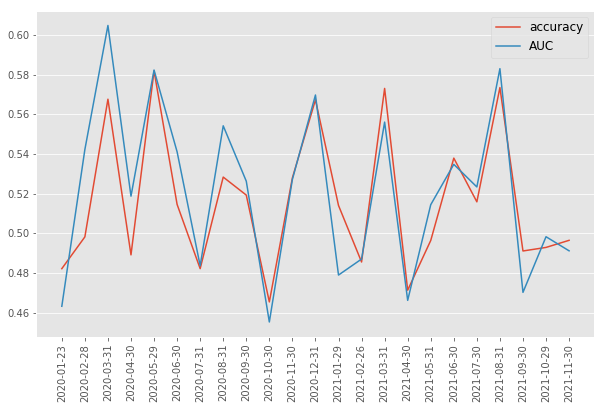

In [80]:
accu_1,auc_1,group_df1 = model_evaluation(knn,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
print(accu_1)
print(auc_1)
plot_accuracy_auc(accu_1,auc_1)

作图成功!


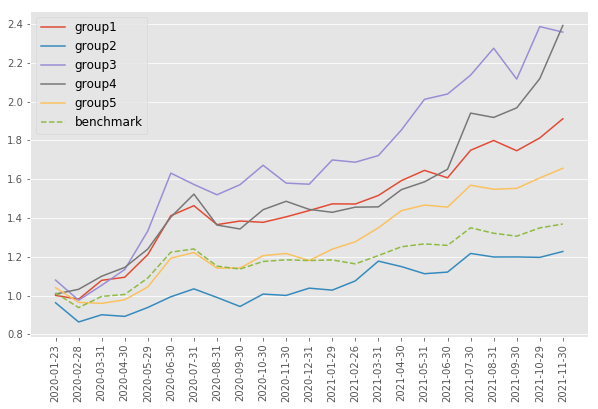

In [81]:
# 净值曲线
visualization(group_df1)

In [82]:
# 策略各项指标
eval1 = evaluation(group_df1)
eval1

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,91.1%,22.7%,135.8%,139.2%,65.6%,36.8%
年化收益率,40.2%,11.26%,56.45%,57.62%,30.1%,17.76%
最大回撤,6.67%,10.29%,9.63%,11.8%,7.77%,8.35%
夏普比率,7.21,1.51,6.84,8.9,5.57,3.08
年化超额收益率,19.25%,-6.16%,34.1%,34.28%,10.37%,0.0%
月最大超额收益,5.57%,6.37%,10.2%,11.47%,4.82%,0.0%
跑赢基准月份占比,78.26%,47.83%,65.22%,69.57%,82.61%,0.0%
正收益月份占比,73.91%,52.17%,65.22%,78.26%,73.91%,65.22%
信息比率,9.65,-1.78,7.51,9.62,5.24,NaN


## 5.2 逻辑回归

**样本内正确率和AUC**

In [83]:
from sklearn.linear_model import LogisticRegression

In [84]:
lg = LogisticRegression()
params = {'C':[0.001,0.01,0.1,1,10,100,1000]
            ,'max_iter':[100,200,300]
            ,'penalty' : ['l1','l2'] }
# lg_GS = GridSearchCV(estimator=lg,param_grid=params,cv=5)
# lg_GS.fit(X_wrapper,y)

# # 输出最佳模型结果
# print(lg_GS.best_score_) #0.547038188631109
# # 输出最佳模型参数
# print(lg_GS.best_params_) #{'C': 1000, 'max_iter': 300, 'penalty': 'l1'}

In [85]:
lg = LogisticRegression(C=1000,max_iter=300,penalty='l1')

In [86]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(lg,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  #accuracy = 0.5458

auc_train = cross_val_score(lg,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))   #auc = 0.5637

样本内交叉验证 : 
	 accuracy = 0.5256
	 auc = 0.5431


In [87]:
lg.fit(X_wrapper,y)
with open('lg.pkl','wb') as pf:
    pickle.dump(lg,pf)

**样本外选股策略表现**

精确度均值: 0.5106578604128089
AUC均值: 0.5243739737450598


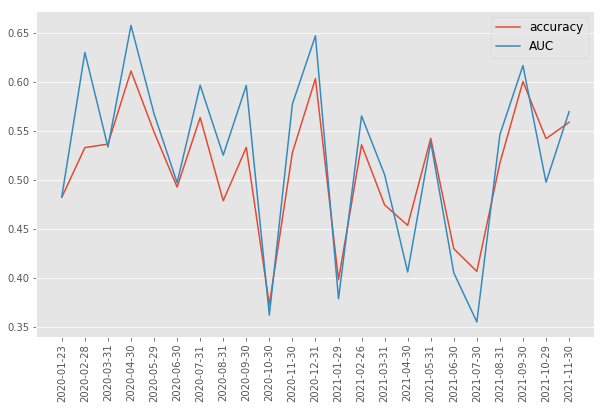

In [88]:
accu_2,auc_2,group_df2 = model_evaluation(lg,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_2,auc_2)

作图成功!


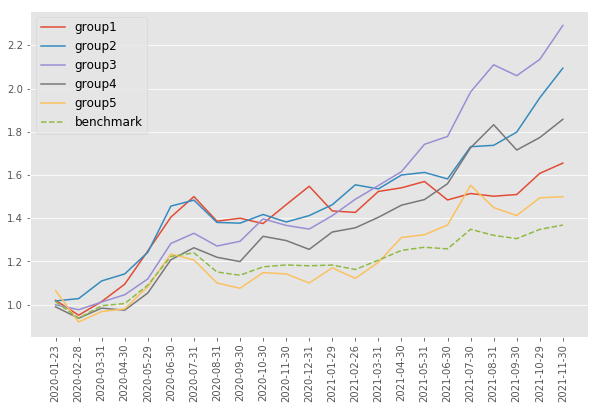

In [89]:
# 净值曲线
visualization(group_df2)

In [90]:
# 策略各项指标
eval2 = evaluation(group_df2)
eval2

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,65.5%,109.5%,129.2%,85.8%,50.0%,36.8%
年化收益率,30.06%,47.09%,54.15%,38.16%,23.56%,17.76%
最大回撤,8.32%,7.18%,4.43%,6.39%,13.66%,8.35%
夏普比率,4.45,8.54,10.83,6.46,2.78,3.08
年化超额收益率,10.5%,24.84%,30.69%,17.3%,5.99%,0.0%
月最大超额收益,6.98%,8.58%,8.42%,8.26%,6.2%,0.0%
跑赢基准月份占比,73.91%,78.26%,73.91%,60.87%,47.83%,0.0%
正收益月份占比,69.57%,78.26%,73.91%,65.22%,60.87%,65.22%
信息比率,3.13,8.97,11.31,6.03,1.63,NaN


## 5.3 决策树

**样本内正确率和AUC**

In [91]:
from sklearn.tree import DecisionTreeClassifier

In [135]:
tree = DecisionTreeClassifier()
params = {'criterion':['gini','entropy']
            ,'max_depth':[*range(3,8)]
            ,'min_samples_split' : [2,10,20,30,60] 
            ,'min_samples_leaf':[1,5,10,20,30]
         }
tree_GS = GridSearchCV(estimator=tree,param_grid=params,cv=5)
tree_GS.fit(X_wrapper,y)

# 输出最佳模型结果
print(tree_GS.best_score_) # 0.5413377979749661
# 输出最佳模型参数
print(tree_GS.best_params_) #{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 2}

0.5326020094320278
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 30}


In [92]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=10,min_samples_leaf=30,min_samples_split=2)

In [93]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(tree,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train)) 
auc_train = cross_val_score(tree,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train)) 

样本内交叉验证 : 
	 accuracy = 0.5145
	 auc = 0.5198


In [94]:
tree.fit(X_wrapper,y)
with open('tree.pkl','wb') as pf:
    pickle.dump(tree,pf)

**样本外选股策略表现**

精确度均值: 0.5100848439809392
AUC均值: 0.5142528278034776


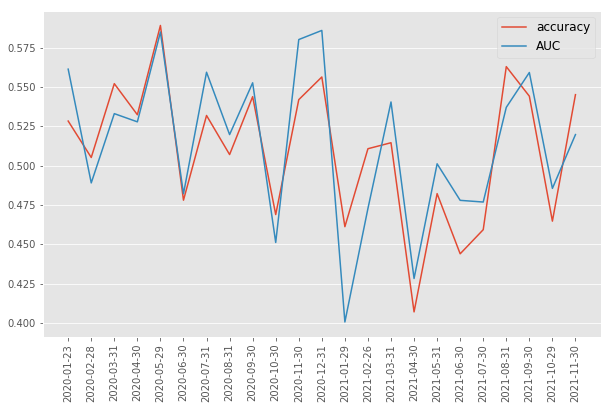

In [95]:
accu_3,auc_3,group_df3 = model_evaluation(tree,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_3,auc_3)

作图成功!


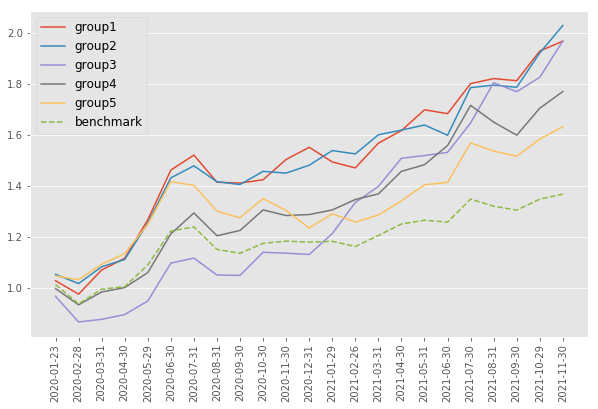

In [96]:
# 净值曲线
visualization(group_df3)

In [97]:
# 这里我之前用不作特征筛选的X,得到第三组的累计收益竟然为 246% 什么鬼???
eval3 = evaluation(group_df3)
eval3

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,96.9%,103.0%,97.0%,77.1%,63.3%,36.8%
年化收益率,42.4%,44.69%,42.44%,34.74%,29.16%,17.76%
最大回撤,7.21%,4.95%,10.4%,6.91%,12.82%,8.35%
夏普比率,7.11,8.26,6.57,6.06,4.84,3.08
年化超额收益率,21.42%,23.15%,20.93%,14.56%,9.79%,0.0%
月最大超额收益,5.04%,4.47%,11.8%,5.67%,6.12%,0.0%
跑赢基准月份占比,78.26%,86.96%,60.87%,69.57%,60.87%,0.0%
正收益月份占比,69.57%,69.57%,69.57%,73.91%,60.87%,65.22%
信息比率,10.77,12.96,5.61,6.69,4.3,NaN


## 5.4 高斯朴素贝叶斯

**样本内正确率和AUC**

In [100]:
from sklearn.naive_bayes import GaussianNB

In [101]:
# 这个是最简单的模型了,没有什么调的参数
bys = GaussianNB()

In [102]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(bys,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))
auc_train = cross_val_score(bys,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))   

样本内交叉验证 : 
	 accuracy = 0.5120
	 auc = 0.5434


In [103]:
bys.fit(X_wrapper,y)
with open('bys.pkl','wb') as pf:
    pickle.dump(bys,pf)

**样本外选股策略表现**

精确度均值: 0.5053082470837075
AUC均值: 0.5319429157422263


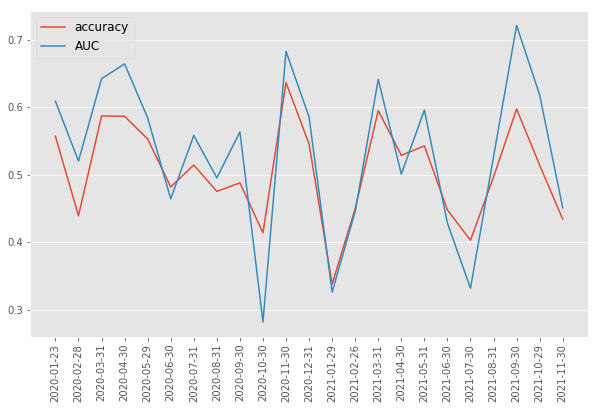

In [104]:
accu_4,auc_4,group_df4 = model_evaluation(bys,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_4,auc_4)

作图成功!


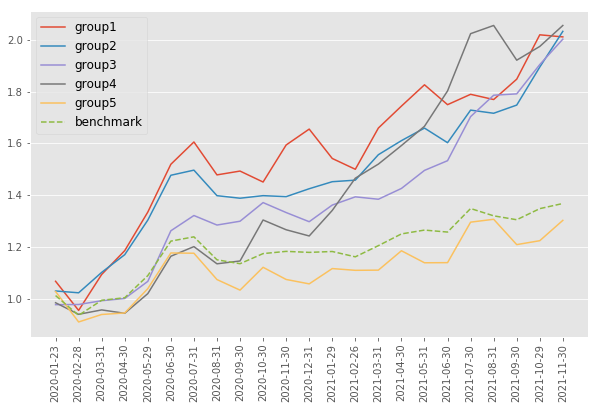

In [105]:
# 净值曲线
visualization(group_df4)

In [106]:
eval4 = evaluation(group_df4)
eval4

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,101.1%,103.2%,100.2%,105.5%,30.4%,36.8%
年化收益率,43.98%,44.76%,43.64%,45.62%,14.85%,17.76%
最大回撤,10.51%,7.23%,5.37%,6.51%,12.16%,8.35%
夏普比率,5.68,8.61,8.23,7.04,1.66,3.08
年化超额收益率,23.05%,22.99%,21.52%,23.6%,-2.01%,0.0%
月最大超额收益,9.11%,6.83%,7.58%,10.99%,6.47%,0.0%
跑赢基准月份占比,65.22%,78.26%,65.22%,60.87%,47.83%,0.0%
正收益月份占比,65.22%,73.91%,78.26%,69.57%,60.87%,65.22%
信息比率,5.56,11.07,7.09,6.21,-0.81,NaN


## 5.5 随机森林

**样本内正确率和AUC**

In [107]:
from sklearn.ensemble import RandomForestClassifier

In [155]:
# 用时: 2h
rfc = RandomForestClassifier()
params = {'n_estimators':[50,100,200,300]
            ,'max_depth':[*range(3,6)]
            ,'min_samples_split' : [2,10,20,30] 
            ,'min_samples_leaf':[1,5,10,20]
         }
rfc_GS = GridSearchCV(estimator=rfc,param_grid=params,cv=5)
rfc_GS.fit(X_wrapper,y)

# 输出最佳模型结果
print(rfc_GS.best_score_)  # 0.5486327034999602
# 输出最佳模型参数
print(rfc_GS.best_params_) #{'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 200}

KeyboardInterrupt: 

In [108]:
rfc = RandomForestClassifier(n_estimators=200
                            ,max_depth=5
                            ,min_samples_leaf=20
                            ,min_samples_split=20
                           )

In [109]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(rfc,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  #accuracy = 0.5474

auc_train = cross_val_score(rfc,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))  #auc = 0.5667

样本内交叉验证 : 
	 accuracy = 0.5361
	 auc = 0.5579


In [111]:
rfc.fit(X_wrapper,y)
with open('rfc.pkl','wb') as fp:
    pickle.dump(rfc,fp)

**样本外选股策略表现**

精确度均值: 0.5265410917248058
AUC均值: 0.5398932261218615


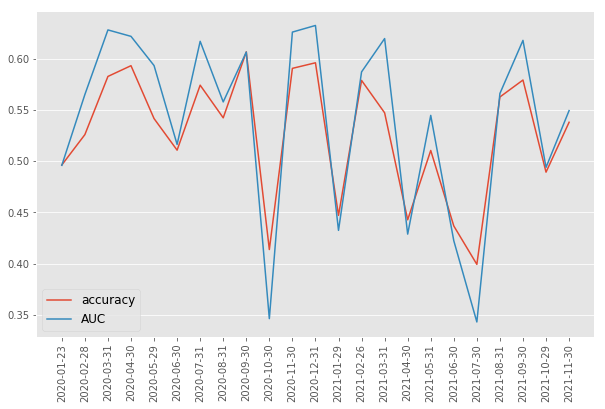

In [112]:
accu_5,auc_5,group_df5 = model_evaluation(rfc,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_5,auc_5)

作图成功!


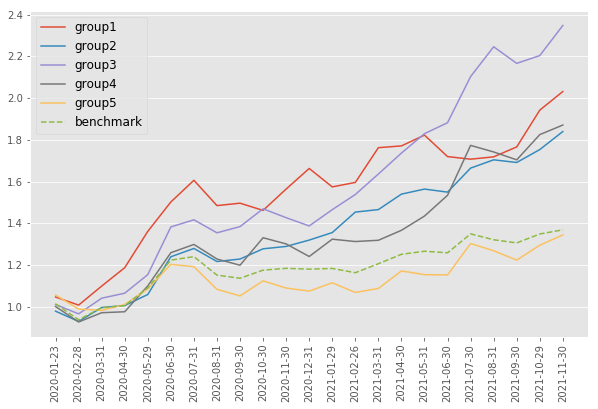

In [113]:
visualization(group_df5)

In [114]:
eval5 = evaluation(group_df5)
eval5

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,103.1%,84.0%,134.8%,87.1%,34.4%,36.8%
年化收益率,44.73%,37.46%,56.1%,38.66%,16.68%,17.76%
最大回撤,8.98%,5.01%,5.59%,7.67%,12.58%,8.35%
夏普比率,6.92,7.25,9.28,5.48,2.26,3.08
年化超额收益率,22.74%,16.5%,33.03%,18.4%,-0.84%,0.0%
月最大超额收益,7.05%,8.97%,8.89%,8.38%,5.84%,0.0%
跑赢基准月份占比,69.57%,78.26%,73.91%,60.87%,43.48%,0.0%
正收益月份占比,73.91%,78.26%,78.26%,65.22%,47.83%,65.22%
信息比率,5.85,7.2,11.86,5.86,-0.36,NaN


## 5.6 Adaboost

**样本内正确率和AUC**

In [115]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoost是英文"Adaptive Boosting"（自适应增强）的缩写，它的自适应在于：前一个基本分类器被错误分类的样本的权值会增大，而正确分类的样本的权值会减小，并再次用来训练下一个基本分类器。同时，在每一轮迭代中，加入一个新的弱分类器，直到达到某个预定的足够小的错误率或达到预先指定的最大迭代次数才确定最终的强分类器。
Adaboost算法可以简述为三个步骤：
（1）首先，是初始化训练数据的权值分布D1。假设有N个训练样本数据，则每一个训练样本最开始时，都被赋予相同的权值：w1=1/N。
（2）然后，训练弱分类器hi。具体训练过程中是：如果某个训练样本点，被弱分类器hi准确地分类，那么在构造下一个训练集中，它对应的权值要减小；相反，如果某个训练样本点被错误分类，那么它的权值就应该增大。权值更新过的样本集被用于训练下一个分类器，整个训练过程如此迭代地进行下去。
（3）最后，将各个训练得到的弱分类器组合成一个强分类器。各个弱分类器的训练过程结束后，加大分类误差率小的弱分类器的权重，使其在最终的分类函数中起着较大的决定作用，而降低分类误差率大的弱分类器的权重，使其在最终的分类函数中起着较小的决定作用。
换而言之，误差率低的弱分类器在最终分类器中占的权重较大，否则较小。

In [116]:
# adb = AdaBoostClassifier()
# params = {
#     'base_estimator':[DecisionTreeClassifier(max_depth=5)],
#     'n_estimators' : [50,100,200,300],
#     'learning_rate': [0.01,0.1,1,10,100]
# }
# adb_GS = GridSearchCV(estimator=adb,param_grid=params,cv=5)
# adb_GS.fit(X_wrapper,y)
# # 输出最佳模型结果
# print(adb_GS.best_score_) 
# # 输出最佳模型参数
# print(adb_GS.best_params_)  #'learning_rate': 0.01, 'n_estimators': 200}

In [117]:
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5)
                         ,learning_rate=0.01
                        , n_estimators=200)

In [118]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(adb,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  #accuracy = 0.5452

auc_train = cross_val_score(adb,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))  #auc = 0.5617

样本内交叉验证 : 
	 accuracy = 0.5289
	 auc = 0.5366


In [121]:
adb.fit(X_wrapper,y)
# with open('adb.pkl','wb') as fp:
#     pickle.dump(adb,fp)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=200, random_state=None)

**样本外选股策略表现**

精确度均值: 0.5305055973361928
AUC均值: 0.5446616941251484


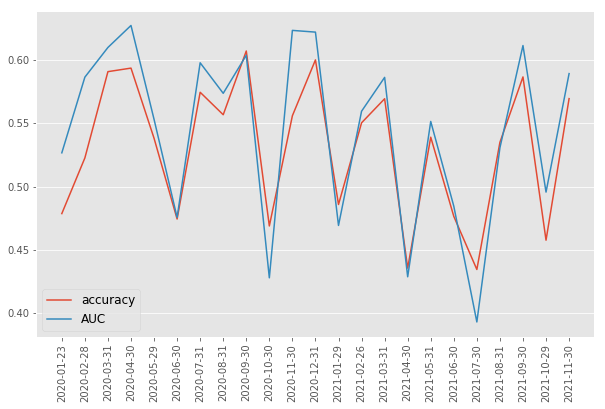

In [122]:
accu_6,auc_6,group_df6 = model_evaluation(adb,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_6,auc_6)

作图成功!


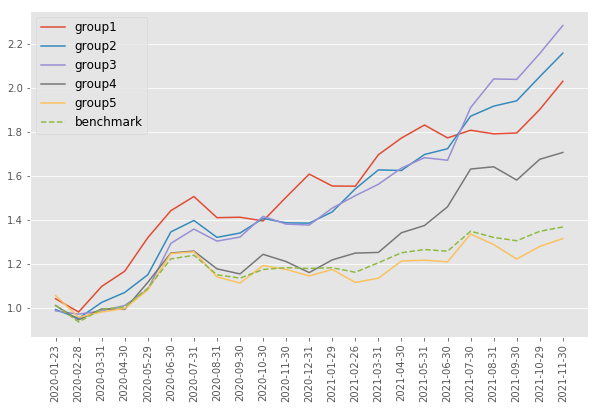

In [123]:
visualization(group_df6)

In [124]:
eval6 = evaluation(group_df6)
eval6

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,102.9%,115.7%,128.2%,70.6%,31.6%,36.8%
年化收益率,44.65%,49.34%,53.8%,32.14%,15.4%,17.76%
最大回撤,7.35%,5.49%,4.03%,8.23%,11.31%,8.35%
夏普比率,7.57,9.65,9.42,5.12,1.9,3.08
年化超额收益率,22.85%,26.81%,30.64%,12.45%,-1.52%,0.0%
月最大超额收益,7.29%,9.0%,8.89%,6.79%,4.36%,0.0%
跑赢基准月份占比,78.26%,82.61%,73.91%,56.52%,39.13%,0.0%
正收益月份占比,69.57%,73.91%,69.57%,69.57%,60.87%,65.22%
信息比率,7.45,11.87,10.26,4.86,-0.95,NaN


## 5.7 支持向量机

**样本内正确率和AUC**

In [127]:
from sklearn.svm import SVC

In [128]:
# 这里参考华泰研报的结果选择的参数, 感兴趣的朋友也可以自己网格搜索一下
svm = SVC(C=0.003,kernel='rbf',gamma=0.01)

In [129]:
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(svm,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  

auc_train = cross_val_score(svm,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))

样本内交叉验证 : 
	 accuracy = 0.5019
	 auc = 0.5300


In [130]:
svm.fit(X_wrapper,y)
# with open('svm.pkl','wb') as fp:
#     pickle.dump(svm,fp)

SVC(C=0.003, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

**样本外选股策略表现**

精确度均值: 0.5040820326326478
AUC均值: 0.530805127265754


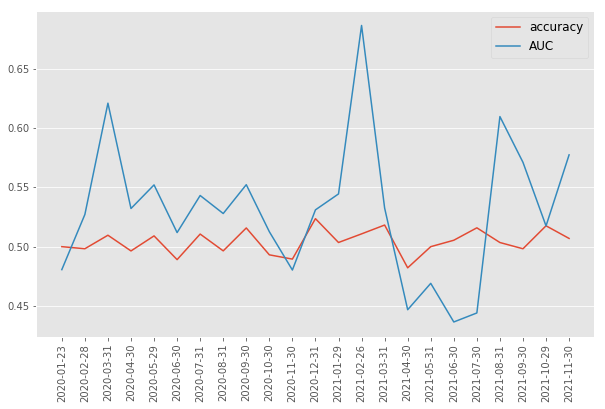

In [131]:
accu_7,auc_7,group_df7 = model_evaluation(svm,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_7,auc_7)

作图成功!


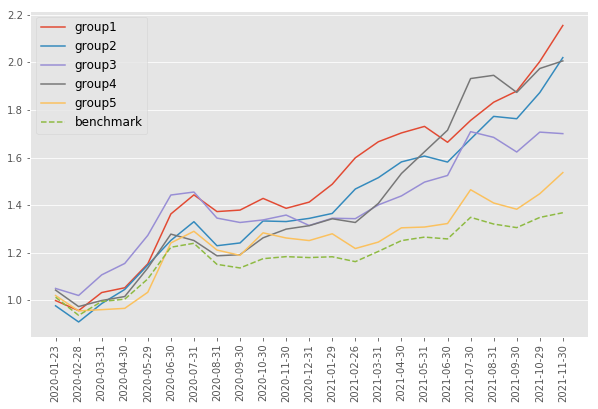

In [132]:
visualization(group_df7)

In [133]:
eval7 = evaluation(group_df7)
eval7

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,115.5%,102.0%,70.1%,100.6%,53.7%,36.8%
年化收益率,49.27%,44.32%,31.94%,43.79%,25.14%,17.76%
最大回撤,4.86%,7.58%,9.66%,7.13%,7.82%,8.35%
夏普比率,8.78,8.3,5.45,7.6,3.57,3.08
年化超额收益率,26.81%,22.42%,12.23%,22.45%,6.66%,0.0%
月最大超额收益,9.18%,9.24%,4.86%,6.19%,7.82%,0.0%
跑赢基准月份占比,78.26%,69.57%,65.22%,86.96%,52.17%,0.0%
正收益月份占比,78.26%,73.91%,65.22%,78.26%,65.22%,65.22%
信息比率,9.68,8.14,6.34,10.23,2.54,NaN


## 5.8 XGBoost

**样本内正确率和AUC**

In [134]:
from xgboost import XGBClassifier

In [135]:
xgb = XGBClassifier(n_estimators=200,max_depth=5)
print('样本内交叉验证 : ')
accuracy_train = cross_val_score(xgb,X_wrapper,y,scoring='accuracy',cv=5).mean()
print('\t','accuracy = %.4f' % (accuracy_train))  

auc_train = cross_val_score(xgb,X_wrapper,y,scoring='roc_auc',cv=5).mean()
print('\t','auc = %.4f' % (auc_train))

样本内交叉验证 : 


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

	 accuracy = 0.5210
	 auc = 0.5306


In [136]:
xgb.fit(X_wrapper,y)
# with open('xgb.pkl','wb') as fp:
#     pickle.dump(xgb,fp)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

**样本外选股策略表现**

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

精确度均值: 0.5257773972140334
AUC均值: 0.536761533056854


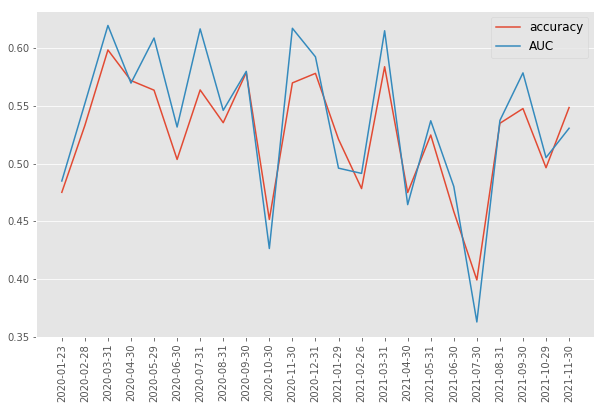

In [137]:
accu_8,auc_8,group_df8 = model_evaluation(xgb,test_dict,trade_days_test,selector)
# 样本外accuracy和auc
plot_accuracy_auc(accu_8,auc_8)

作图成功!


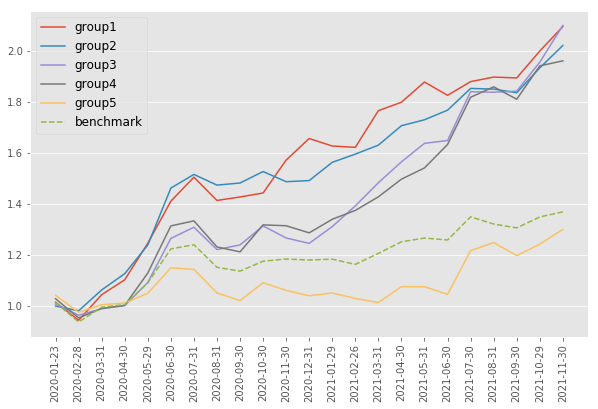

In [138]:
visualization(group_df8)

In [139]:
eval8 = evaluation(group_df8)
eval8

,第一组,第二组,第三组,第四组,第五组,比较基准
累计收益率,109.4%,102.0%,109.8%,96.0%,30.0%,36.8%
年化收益率,47.05%,44.32%,47.2%,42.06%,14.67%,17.76%
最大回撤,6.97%,2.76%,6.68%,9.11%,11.81%,8.35%
夏普比率,7.98,8.76,8.32,6.64,1.97,3.08
年化超额收益率,25.16%,22.44%,25.27%,21.3%,-2.81%,0.0%
月最大超额收益,8.2%,5.79%,7.9%,6.55%,9.19%,0.0%
跑赢基准月份占比,78.26%,78.26%,82.61%,69.57%,39.13%,0.0%
正收益月份占比,73.91%,73.91%,78.26%,73.91%,56.52%,65.22%
信息比率,9.42,10.57,10.57,9.43,-0.93,NaN


# 总结

In [141]:
models = ['KNN','Logistic','DecisionTree','Bayes','RF','AdaBoost','SVM','XGBoost']

## 各个模型样本外精确度和AUC
各个模型好像都差不多,其中逻辑回归表现最好

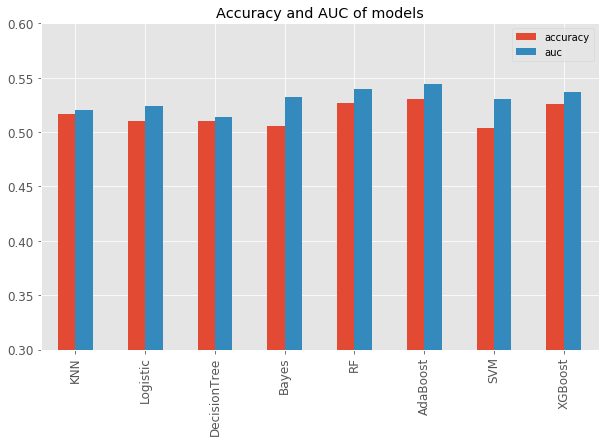

In [142]:
df = pd.DataFrame([[mean(accu_1), mean(accu_2),mean(accu_3),mean(accu_4),mean(accu_5),mean(accu_6),mean(accu_7),mean(accu_8)]
                      ,[mean(auc_1), mean(auc_2),mean(auc_3),mean(auc_4),mean(auc_5),mean(auc_6),mean(auc_7),mean(auc_8)]]
                 ,index=['accuracy','auc']).T
df.index = models

df.plot(kind='bar',figsize=(10,6),ylim=[0.3,0.6],title='Accuracy and AUC of models',fontsize=12)

plt.show()

## 各个模型组合1的净值曲线

In [168]:
group1_all = pd.DataFrame(index=group_df1.index,columns=models+['benchmark'])

In [169]:
for i,df in enumerate([group_df1,group_df2,group_df3,group_df4,group_df5,group_df6,group_df7,group_df8]):
    if i == 7:
        group1_all.iloc[:,i+1] = df['benchmark']
    group1_all.iloc[:,i] = df['group1']


可以看到 , 所有模型的组合1都跑赢了中证500 ,其中SVM的表现最好

In [170]:
(group1_all+1).cumprod().iloc[-1,:].sort_values()

benchmark       1.368493
Logistic        1.655284
KNN             1.911100
DecisionTree    1.968647
Bayes           2.010526
AdaBoost        2.029104
RF              2.031321
XGBoost         2.094104
SVM             2.155075
Name: 2021-11-30, dtype: float64

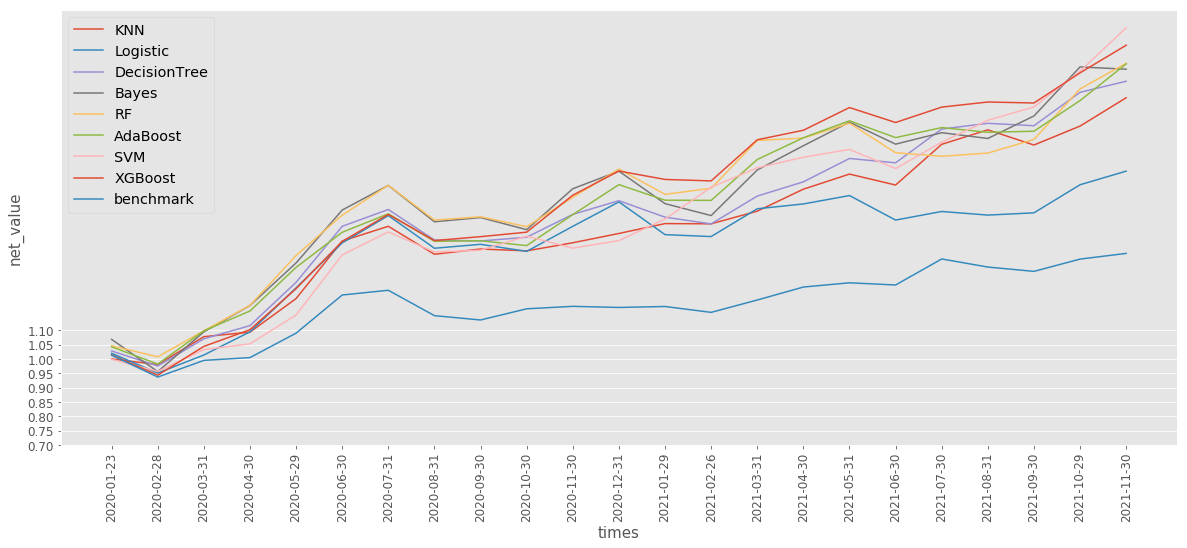

In [171]:
plt.figure(figsize=(20,8))
group1_all.index = [str(i) for i in group1_all.index]
plt.plot((group1_all+1).cumprod())
plt.xlabel('times',fontsize=15)
plt.ylabel('net_value',fontsize=15)
plt.xticks(rotation=90,fontsize=12)
plt.yticks([0.7,0.75,0.8,0.85,0.9,0.95,1.0,1.05,1.1],fontsize=12)
plt.legend(group1_all.columns,fontsize='x-large')
plt.grid(axis='x')
plt.show()

## 各个模型组合1的策略评价指标

In [161]:
eval_df = pd.DataFrame(index=eval1.index,columns=models)

In [162]:
for i,df in enumerate([eval1,eval2,eval3,eval4,eval5,eval6,eval7,eval8]):
    if i == 7:
        eval_df['benchmark'] = df['比较基准']
    eval_df.iloc[:,i] = df['第一组']

In [163]:
eval_df

,KNN,Logistic,DecisionTree,Bayes,RF,AdaBoost,SVM,XGBoost,benchmark
累计收益率,91.1%,65.5%,96.9%,101.1%,103.1%,102.9%,115.5%,109.4%,36.8%
年化收益率,40.2%,30.06%,42.4%,43.98%,44.73%,44.65%,49.27%,47.05%,17.76%
最大回撤,6.67%,8.32%,7.21%,10.51%,8.98%,7.35%,4.86%,6.97%,8.35%
夏普比率,7.21,4.45,7.11,5.68,6.92,7.57,8.78,7.98,3.08
年化超额收益率,19.25%,10.5%,21.42%,23.05%,22.74%,22.85%,26.81%,25.16%,0.0%
月最大超额收益,5.57%,6.98%,5.04%,9.11%,7.05%,7.29%,9.18%,8.2%,0.0%
跑赢基准月份占比,78.26%,73.91%,78.26%,65.22%,69.57%,78.26%,78.26%,78.26%,0.0%
正收益月份占比,73.91%,69.57%,69.57%,65.22%,73.91%,69.57%,78.26%,73.91%,65.22%
信息比率,9.65,3.13,10.77,5.56,5.85,7.45,9.68,9.42,NaN
